In [1]:

import tensorflow as tf
# tf.enable_eager_execution()
import os
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import keras
# import datetime as dt
from datetime import datetime

import time
# import datetime.datetime



from keras import layers
from keras import models
# from keras import optimizers
from tensorflow.keras import optimizers

from keras.applications.densenet import DenseNet121, DenseNet169
#from keras.applications.nasnet import NASNetLarge
# from keras_efficientnets import EfficientNetB7
from keras.layers import *
from keras.models import *
from keras import initializers, regularizers, constraints
from keras.layers.normalization import BatchNormalization 
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras import backend as K

tf.set_random_seed(1234)
random.seed(100)

os.environ["CUDA_VISIBLE_DEVICES"]="1"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
import os

from tensorflow.keras.models import load_model

from ABNmodules import *

loss_function = 'categorical_crossentropy'
activation_function = 'softmax'


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
def get_unique_classes(input_directory,files):

    unique_classes=set()
    for f in files:
        g = f.replace('.mat','.hea')
        input_file = os.path.join(input_directory,g)
        with open(input_file,'r') as f:
            for lines in f:
                if lines.startswith('#Dx'):
                    tmp = lines.split(': ')[1].split(',')
                    for c in tmp:
                        unique_classes.add(c.strip())
    return sorted(unique_classes)

def one_hot_encoding(one_hot_vector,y, class2index):
    ind=class2index[y]
    one_hot_vector[ind]=1
    return one_hot_vector

# Search for multi-label subjects
def searching_overlap(input_directory,class2index, input_file_names):
    multiclasses=[]
    multisubjects=[]
    number = []
    for file in input_file_names:
        f=file
        g = f.replace('.mat','.hea')
        input_file = os.path.join(input_directory,g)
        with open(input_file,'r') as f:
            for lines in f:
                if lines.startswith('#Dx'):
                    tmp = lines.split(': ')[1].split(',')
                    if len(tmp)>1:
                        one_hot_vector = [0]*(len(class2index))
                        for c in tmp:
                            one_hot_vector = one_hot_encoding(one_hot_vector, c.strip(), class2index)
                        multiclasses.append(one_hot_vector)
                        multisubjects.append(g)
                        number.append(len(tmp))
    return multisubjects, multiclasses, number

def block_feature(sequence_en, minimum_len): 
    new_en = []
    if len(sequence_en) > minimum_len:  # 길이가 minimum보다 긴 경우
        start = random.randint(0,len(sequence_en)-minimum_len)
        #print(start)
        new_en = sequence_en[start:start+minimum_len]
    elif len(sequence_en) == minimum_len: # 길이가 minimum
        new_en = sequence_en
    else: 
        assert len(sequence_en) <= minimum_len
    return new_en

def exploratory_look(input_directory,file, class2index):
    classes = []
    f = file
    g = f.replace('.mat','.hea')
    input_file = os.path.join(input_directory,g)
    with open(input_file,'r') as f:
        for lines in f:
            if lines.startswith('#Dx'):
                tmp = lines.split(': ')[1].split(',')
                print(tmp, len(tmp))
    return tmp     

# Get classes of sorted file names
def get_labels(input_directory,file, class2index):
    f = file
    g = f.replace('.mat','.hea')
    input_file = os.path.join(input_directory,g)
    with open(input_file,'r') as f:
        for lines in f:
            if lines.startswith('#Dx'):
                tmp = lines.split(': ')[1].split(',')
                one_hot_vector = [0]*(len(class2index))
                for c in tmp:
                    one_hot_vector = one_hot_encoding(one_hot_vector, c.strip(), class2index)
                
    return one_hot_vector

def randextract_mels(curr_step, batch_size, data, mel_directory, class2index, minimum_len, x_mean_final, x_std_final):
    mel_files = []
    classes = []
    start = batch_size*curr_step
    end = batch_size*(curr_step+1)
    curr_file_indices = data[start:end]
    for file in curr_file_indices:
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        clip_file = block_feature(tmp_file, minimum_len)
        #print(clip_file.shape)
        #clip_file = tmp_file[:minimum_len]
        clip_file -= x_mean_final
        clip_file /= x_std_final
        mel_files.append(clip_file)
        label = get_labels(input_directory, file, class2index)
        classes.append(label)
    concat = list(zip(mel_files, classes))
    random.shuffle(concat)
    mel_files, classes = zip(*concat)
    return mel_files, classes

def train(data_train, mel_directory, batch_size, class2index, minimum_len, x_mean_final, x_std_final): 
    loss=[]
    acc = []
    f1 = []

    total_steps = int(np.ceil(len(data_train)/batch_size))
    for curr_step in range(total_steps):
        batch_mels, batch_labels = randextract_mels(curr_step, batch_size, data_train, mel_directory, class2index, minimum_len, x_mean_final, x_std_final)
        batch_mels = np.asarray(batch_mels)
        batch_labels = np.asarray(np.squeeze(batch_labels))
        train_tmp = model.train_on_batch(batch_mels, batch_labels)
        loss.append(train_tmp[0])
        acc.append(train_tmp[1])
        f1.append(train_tmp[2])

    loss = np.mean(np.array(loss))
    acc = np.mean(np.array(acc))
    f1 = np.mean(np.array(f1))
    return loss, acc, f1

def test(data, mel_directory, input_directory, class2index, minimum_len, model, x_mean_final, x_std_final):
    scores = []
    predicted_labels=[]
    accuracy=np.zeros(len(data))
    #total_loss=[]
    total_acc = 0
    total_f1 = 0
    
    mel_files = []
    classes = []
    for i, file in enumerate(data):
        tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
        steps = int(np.floor(tmp_file.shape[0]/minimum_len))
        mel_files = []
        for block in range(steps): # 128개씩 쪼갠 블럭 단위로 predict
            start = block*minimum_len
            end = (block+1)*minimum_len
            clip_file = tmp_file[start:end]
            clip_file -= x_mean_final
            clip_file /= x_std_final
            mel_files.append(clip_file)
        mel_files = np.asarray(mel_files)
        logit = model.predict(mel_files)
        logit = np.mean(logit, axis=0)
        pred = np.argmax(logit)
        label = np.argmax(get_labels(input_directory, file, class2index))
        #f1 = f1_score(label, logit)
        #print(pred, label)
        if pred == label:
            acc = 1
        else:
            acc = 0
        total_acc += acc
        #total_f1 += f1
    final_acc = total_acc / i
    #final_f1 = total_f1 / i
    return final_acc#, final_f1

batch_size = 32
minimum_len = 2880

epochs = 1000
loss_function = 'categorical_crossentropy'
activation_function = 'softmax'
rootdir = '../'
date = datetime.today().strftime("%Y%m%d")
input_directory = os.path.join(rootdir, 'Training_WFDB')
mel_name = 'Raw_data_20200424' 
mel_directory = os.path.join(rootdir, mel_name)
results_directory = os.path.join(rootdir, 'results_'+date+'_0')
if not os.path.isdir(input_directory):
    os.mkdir(input_directory)
if not os.path.isdir(mel_directory):
    os.mkdir(mel_directory)
if not os.path.isdir(results_directory):
    os.mkdir(results_directory)
        
input_files = []
for f in os.listdir(input_directory):
    if os.path.isfile(os.path.join(input_directory, f)) and not f.lower().startswith('.') and f.lower().endswith('mat'):
        input_files.append(f)
input_file_names = sorted(input_files)

unique_classes = get_unique_classes(input_directory, input_files)
class2index = {}
for a, b in enumerate(unique_classes):
    class2index[b] = a
index2class = {y:x for x,y in class2index.items()}    
classes_orig= [x.replace('.mat', '.hea') for x in input_file_names] # total subjects
classes_multi, _, _ = searching_overlap(input_directory,class2index, input_file_names)
classes_single = [x for x in classes_orig if x not in classes_multi]
classes_single = [x.replace('.hea', '.mat') for x in classes_single]

# double-checking if classes_single have single-label
a, b, c  = searching_overlap(input_directory,class2index,classes_single)

# we can safely use classes_single as input_file_names
input_file_names = classes_single
random.shuffle(input_file_names)
np.shape(input_file_names)

x_mean_all = []
x_std_all = []

for file in input_file_names:
    x = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
    x_mean = [np.mean(x[:,0]), np.mean(x[:,1]), np.mean(x[:,2]), np.mean(x[:,3]), np.mean(x[:,4]), np.mean(x[:,5]),
             np.mean(x[:,6]), np.mean(x[:,7]), np.mean(x[:,8]), np.mean(x[:,9]), np.mean(x[:,10]), np.mean(x[:,11])]
    
    x_std = [np.std(x[:,0]), np.std(x[:,1]), np.std(x[:,2]), np.std(x[:,3]), np.std(x[:,4]), np.std(x[:,5]),
             np.std(x[:,6]), np.std(x[:,7]), np.std(x[:,8]), np.std(x[:,9]), np.std(x[:,10]), np.std(x[:,11])]
    #print(x_mean)
    x_mean_all.append(x_mean)
    x_std_all.append(x_std)
x_mean_final = np.mean(x_mean_all, axis=0)
x_std_final = np.mean(x_std_all, axis=0)
print(x_mean_final)

data, data_test = train_test_split(input_file_names, test_size = 0.2, train_size = 0.8, shuffle=True)
data_train, data_val = train_test_split(data, test_size = 0.25, train_size = 0.75, shuffle=True)
print(np.shape(data_train), np.shape(data_val), np.shape(data_test))


file=data_train[0]
tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
clip_file = block_feature(tmp_file, minimum_len)

clip_file -= x_mean_final
clip_file /= x_std_final
clip_file.shape

preprocessed_input=clip_file

preprocessed_input.shape

preprocessed_input = np.reshape(preprocessed_input, (1,minimum_len,12))

preprocessed_input.shape

[-2.24290386e-03 -4.58280585e-05  4.31697309e-03 -3.00174693e-03
 -2.36609229e-04  1.28997408e-03  2.17347589e-04 -7.99152384e-04
 -3.42993744e-03 -1.69711686e-03  1.27138164e-03  1.94670545e-03]
(3840,) (1280,) (1281,)


(1, 2880, 12)

In [3]:
def score_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [4]:
model_dir = '/home/taejoon/PhysioNetChallenge/results_20200601_1_CAM_primitive_model'
minimum_len = 2880

bestmodel = 'ECG_ABN_E87L0.33'

In [5]:
model = load_model(os.path.join(model_dir, bestmodel), custom_objects={'score_f1' : score_f1})

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [6]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, None, 12)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          2368      
_________________________________________________________________
batch_normalization (BatchNo (None, None, 64)          256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          12352     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 64)          256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)         24704 

In [16]:
conv_out = model.get_layer('batch_normalization_12')
softmax_weights = model.get_layer('dense_final').get_weights()[0]
# len(softmax_weights[0][0]) # size of softmax_weights = (2, 128, 9) -> 첫 번쨰 2는 weight, bias인듯 

In [17]:
def grad_cam_conv1D(model, layer_nm, x, save_dir, x_mean_final, x_std_final, minimum_len, n_channels, n_classes,sample_weight=1,  keras_phase=0):
    
    #레이어 이름에 해당되는 레이어 정보를 가져옴 
    layers_wt = model.get_layer(layer_nm).weights
    layers = model.get_layer(layer_nm)
    layers_weights = model.get_layer(layer_nm).get_weights()
    
    conv_out = model.get_layer('batch_normalization_12')
    softmax_weights = model.get_layer('dense_final').get_weights()[0]
    
    # preprocessing x
    tmp_file = np.load(mel_directory + '/' + file.replace('.mat', '.npy'))
    clip_file = block_feature(tmp_file, minimum_len)
    clip_file -= x_mean_final
    clip_file /= x_std_final    
    clip_file = clip_file.reshape(1,minimum_len, n_channels)
    
    classes=[]
    for label in range(n_classes):
        
        savepath = os.path.join(save_dir, file.replace('.mat', '.npy'))
    
        #긍정 클래스를 설명할 수 있게 컨볼루션 필터 가중치의 gradient를 구함  
        grads = K.gradients(model.output[:,label], layers_wt)[0]

        #필터별로 가중치를 구함 
        pooled_grads = K.mean(grads, axis=(0,1))
        get_pooled_grads = K.function(model.input, 
                             [pooled_grads, layers.output[0]])
        
        pooled_grads_value, conv_layer_output_value = get_pooled_grads(clip_file)

        #다시한번 이야기 하지만 loss를 줄이기 위한 학습과정이 아니다... 
        for i in range(conv_layer_output_value.shape[-1]):
            conv_layer_output_value[:, i] *= pooled_grads_value[i]

        heatmap = np.mean(conv_layer_output_value, axis=-1)
    #     heatmap = np.maximum(heatmap, 0)
    #     heatmap = heatmap/np.max(heatmap)
#         hm = cv2.resize(heatmap, (1,2880)) # 속도가 넘 느린데.. 얘를 resize 안하면 나아지려나?
#         classes.append(hm)
        classes.append(heatmap)
#     np.save(savepath, classes)
    

In [71]:
np.zeros((1,37))


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]])

In [29]:
clip_file.shape
clip_file=clip_file.reshape(1,2880,12)

In [48]:
layer_nm = 'batch_normalization_12'
conv_out = model.get_layer(layer_nm)
softmax_out = model.get_layer('dense_final')
softmax_weights = softmax_out.weights
# softmax_weights = model.get_layer('dense_final').get_weights()[0]
get_conv_out = K.function(model.input, [conv_out.output, softmax_weights[0]])
conv_out, softmax_weights = get_conv_out(clip_file)

curr_weights = softmax_weights[:,curr_class]
weighted_conv = conv_out*curr_weights


# len(conv_out) # 1, 1, 36, 128
# len(softmax_weights[0][0][0]) # 2, 128, 9

In [72]:
3840/32

120.0

In [51]:
curr_class = 8
curr_weights = softmax_weights[:,curr_class]
curr_weights.shape

(128,)

In [53]:
a = conv_out*curr_weights
a.shape

(1, 36, 128)

In [55]:
b =a.sum(axis=2)
b.shape

(1, 36)

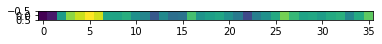

In [57]:
plt.imshow(b)

In [67]:
bb=np.resize(b,(1,2880))

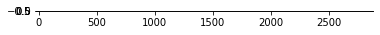

In [68]:
plt.imshow(bb)

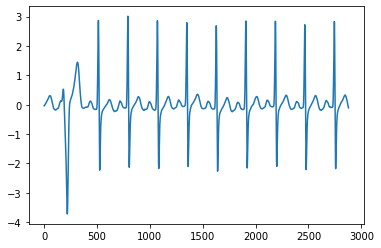

In [62]:
c = clip_file[:,:,curr_class]
plt.plot(c.reshape(2880,1))

In [ ]:
np.dot

In [ ]:
save_dir = os.path.join(model_dir, "GradCAM_ROI_2")
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
n_channels=12
n_classes = 9
import cv2
# for i,file in enumerate(data_train):
for file in data_train:
    grad_cam_conv1D(model, 'conv1d_12',  file, save_dir, x_mean_final, x_std_final,  minimum_len, n_channels, n_classes)
    print("finished {}".format(file))

### Checking ROI

In [ ]:
plt.plot(heatmap.reshape(36,1))


In [ ]:
hm = cv2.resize(heatmap, (1,2880))
plt.plot(hm)

In [ ]:
dot2 = hm * x
dot2.shape


In [ ]:
for i in range(12):
    plt.subplot(12,1,i+1)
    plt.pcolor(np.reshape(dot2[:,:,i], (1,2880)))

In [ ]:
for i in range(12):
    plt.subplot(12,1,i+1)
    plt.plot(np.reshape(clip_file[:,i], (2880,1)))

In [ ]:
heatmap.shape

In [ ]:
import cv2
hm = cv2.resize(heatmap, (1,2880))

In [ ]:
img = cv2.resize(x[:,:,0], (1,2880))

In [ ]:
x.shape

In [ ]:
hm.shape

In [ ]:
img.shape

In [ ]:
hm = np.uint8(255 * hm)

In [ ]:
hm = cv2.applyColorMap(hm, cv2.COLORMAP_JET)

In [ ]:
superimposed_img = hm*0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)


In [ ]:
from IPython.display import Image

In [ ]:
clip_file.shape


In [ ]:
aaa = clip_file[:,0]


aaa.reshape(1,2880)
aaa.shape



In [ ]:
# clip_file[:,0]
plt.imshow(np.transpose(clip_file))








In [ ]:
plt.matshow(hm)




In [ ]:
plt.imshow(aaa.reshape(1,2880))





In [ ]:
save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)
display(Image(save_path))


In [ ]:
plt.imshow(superimposed_img)

In [ ]:
hm = np.mean(conv_layer_output_value, axis=-1)
graded = pooled_grads_value

In [ ]:
hm_tbl = pd.DataFrame({'heat':hm, 'kw':[keyword_rev_dict[i] for i in test_x[idx] ]})

In [ ]:
plt.plot(conv_layer_output_value)

In [ ]:
c = conv_layer_output_value.resize()

In [ ]:
print(model.sample_weights)

In [ ]:
classifier_layer_names = [ "global_average_pooling1d",
    "dense", "batch_normalization_13", "activation", "dense_1", "batch_normalization_14", "activation_1", "dense_final"
    , "output"
]

last_conv_layer = model2.get_layer('max_pooling1d_4') # 암튼 GAP 직전 layer 불러오기 
last_conv_layer_model = Model(model2.inputs, last_conv_layer.output)

classifier_input = Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input
for layer_name in classifier_layer_names:
    print(layer_name)
    x = model.get_layer(layer_name)(x)
classifier_model = Model(classifier_input, x)

In [ ]:
last_conv_layer_model.summary()

In [ ]:
classifier_model.summary()

In [ ]:
preprocessed_input.shape

In [ ]:
with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        p = tf.convert_to_tensor(preprocessed_input, dtype="float32")
#         if dtype(p) == 'float64':
#             p = tf.cast(p, 'float32')
        last_conv_layer_output = last_conv_layer_model(p)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

In [ ]:
grads = tf.gradients(top_class_channel, last_conv_layer_output)

In [ ]:
grads

In [ ]:
pooled_grads = tf.reduce_mean(grads, axis=(1,2))

In [ ]:
pooled_grads = K.eval(pooled_grads)

In [ ]:
pooled_grads.shape

In [ ]:
pooled_grads

In [ ]:
last_conv_layer_output =K.eval(last_conv_layer_output)[0]

In [ ]:
last_conv_layer_output

In [ ]:
last_conv_layer_output.shape

In [ ]:
pooled_grads.shape[-1]

In [ ]:
for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[i] *= pooled_grads[i]

In [ ]:
def grad_cam_conv1D(model, layer_nm, x, sample_weight=1, keras_phase=0):
    # 레이어 이름에 해당하는 레이어 정보를 가져옴
    layers_wt = model.get_layer(layer_nm).weights
    layers = model.get_layer(layer_nm)
    layers_weights = model.get_layer(layer_nm).get_weights()
    
    # 긍정 클래스를 설명할 수 있게 컨볼루션 필터 가중치의 gradient를 구함
    grads = K.gradients(model.output[:,0], layers_wt)[0]
    
    # 필터별로 가중치를 구함
    pooled_grads = K.mean(grads, axis=(0,1))

In [ ]:
model2.output


In [ ]:
output_wrt_class = model2.output[:,1] # [:,i] : i가 관심있는 class
output_wrt_class

In [ ]:
grads = K.gradients(output_wrt_class, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0,1)) # tf.reduce_sum이랑 비슷한듯; 여긴 1d이니까 0,1,2가 아니라 0,1만?
iterate = K.function([model2.input],[pooled_grads, last_conv_layer.output[0]])

In [ ]:
x=preprocessed_input
pooled_grads_value, conv_layer_output_value = iterate([x])

In [ ]:
pooled_grads_value

In [ ]:
pooled_grads_value.shape

In [ ]:
conv_layer_output_value

In [ ]:
conv_layer_output_value.shape

In [ ]:
for i in range(128):
        conv_layer_output_value[:,i] *= pooled_grads_value[i]

In [ ]:
conv_layer_output_value

In [ ]:
heatmap = np.mean(conv_layer_output_value, axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap = heatmap/np.max(heatmap)
print(heatmap)